In [1]:
from pathlib import Path
from torch.utils.data import Dataset
from monai.transforms import Compose, Transform, LoadImage, EnsureChannelFirst, Lambda, RepeatChannel, Resize, SpatialPad, ScaleIntensity, NormalizeIntensity, RandRotate, RandAffine, RandFlip, RandGaussianNoise
from monai.data import Dataset  
import pandas as pd
import shutil
import random
import sys
import torch
import cv2
from torch.utils.data import Subset

In [2]:
def clean_data():
    csv_path = Path("../data/raw/paths_to_delete.csv")
    source_dir = Path("../data/raw/unzipped_raw_data")
    cleaned_dir = Path("../data/interim/cleaned_data")

    # --- Abort if already cleaned ---
    if cleaned_dir.exists():
        print(f"[INFO] {cleaned_dir} already exists.")
        return

    # --- Copy raw data ---
    print("Copying raw/unzipped_raw_data → data/interim/cleaned_data ...")
    shutil.copytree(source_dir, cleaned_dir)

    # --- Load paths to delete ---
    df = pd.read_csv(csv_path)

    deleted = 0
    

    # --- Delete files from copied data only ---
    deleted = 0
    for p in df["path"]:
      
      fp = Path(p.replace("../data/raw/unzipped_raw_data", "data/interim/cleaned_data"))
      if fp.exists():
          fp.unlink()
          deleted += 1

    print(f"Deleted {deleted} files from interim/cleaned_data.")
    
    return clean_data
    

In [3]:
clean_data() 

[INFO] ../data/interim/cleaned_data already exists.


In [4]:
def data_load(data_dir, inspect=True, n_samples=3):
    """
    Create a MONAI Dataset, ensure channels come first, and optionally inspect sample properties.

    Parameters
    ----------
    data_dir : str or Path
        Root directory containing image files.
    inspect : bool
        Whether to print sample dataset information.
    n_samples : int
        Number of samples to inspect. samples are chosen randomly.

    Returns
    -------
    dataset : monai.data.Dataset
        Lazy-loading MONAI dataset.    
    """
    data_dir = Path(data_dir)
    image_paths = list(data_dir.rglob("*.jpg"))

    transforms = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
    ])

    dataset = Dataset(
        data=image_paths,
        transform=transforms
    )

    # 🔍 Lightweight inspection
    if inspect and len(dataset) > 0:
        print(f"Dataset size: {len(dataset)} images")

        sample_indices = random.sample(
            range(len(dataset)),
            min(n_samples, len(dataset))
        )

        for idx in sample_indices:
            img = dataset[idx]
            print(
                f"Sample {idx}: "
                f"shape={tuple(img.shape)}, "
                f"dtype={img.dtype}, "
                f"min={float(img.min()):.2f}, "
                f"max={float(img.max()):.2f}"
            )

    return dataset

Dataset size: 14373 images
Sample 11377: shape=(3, 1330, 855), dtype=torch.float32, min=0.00, max=255.00
Sample 13207: shape=(3, 1024, 1024), dtype=torch.float32, min=0.00, max=255.00
Sample 10401: shape=(3, 1280, 736), dtype=torch.float32, min=0.00, max=255.00
Sample 11527: shape=(3, 864, 464), dtype=torch.float32, min=0.00, max=255.00
Sample 2407: shape=(3, 1024, 1024), dtype=torch.float32, min=0.00, max=255.00


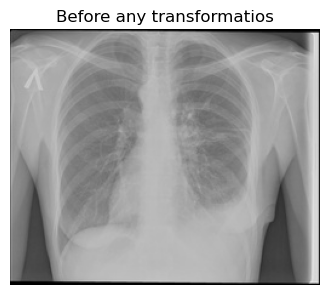

torch.Size([3, 256, 211])

In [5]:
# test 
test_data=data_load(data_dir='../data/interim/cleaned_data', inspect=True, n_samples=5)

import matplotlib.pyplot as plt
import numpy as np

img0_hwc = test_data[13589].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(4,4))
plt.imshow(np.rot90(img0_hwc.astype("uint8"),k=3))
plt.axis("off")
plt.title("Before any transformatios")
plt.show()

test_data[13589].shape


In [12]:
class GCLAHE(Transform):
    """
    
    Create a Global-CLAHE transformation for image enhancement more suited for medical images.
    Improves local contrast while preserving anatomical detail in medical images

    """
    
    def __init__(self, tile_grid_size=(8, 8), max_clip_limit=3.0):
        self.tile_grid_size = tile_grid_size
        self.max_clip_limit = max_clip_limit

    def __call__(self, img_tensor):
        #  (C, H, W) tensor to (H, W, C) numpy for ease of channel processing now. Will reverse it back later
        img_np = img_tensor.detach().cpu().numpy()
        
        processed_channels = []
        # Process each of the 3 channels individually
        for c in range(img_np.shape[0]):
            # 1. Scale to uint8 for OpenCV
            channel = (img_np[c] * 255).astype(np.uint8)
            
            # 2. Global Reference (GEI)
            gei = cv2.equalizeHist(channel)
            
            # 3. Local Enhancement (CLAHE)
            clahe = cv2.createCLAHE(clipLimit=self.max_clip_limit, tileGridSize=self.tile_grid_size)
            lei = clahe.apply(channel)
            
            # 4. G-CLAHE Blending: Maintain global brightness consistency
            # 50/50 blend is common to prevent local artifacts
            g_clahe_channel = cv2.addWeighted(lei, 0.5, gei, 0.5, 0)
            
            processed_channels.append(g_clahe_channel.astype(np.float32) / 255.0)
            
        # back to (3, H, W)
        return torch.from_numpy(np.stack(processed_channels))

def transform(dataset):
    """
    Return a new transformed Dataset
     a- convert to grayscale by averaging channels since some images have incononsistent channels
     b- repeat channels to have 3 channels again.
     c- resize to 224x224
     d- pad to ensure 224x224
     e- scale intensity to [0,1]
     f- apply G-CLAHE Transform class
     g- normalize intensity with ImageNet stats

    Parameters
    ----------
    dataset : monai.data.Dataset
        Existing dataset (paths will be reused).

    Returns
    -------
    dataset_transformed : monai.data.Dataset
        New dataset after applying the transformations.
    """
    image_paths = dataset.data  
    
    to_gray = Lambda(lambda x: x.mean(dim=0, keepdim=True))

    transforms = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        to_gray,
        RepeatChannel(3),
        Resize((224, 224), mode='bilinear'),
        SpatialPad(spatial_size=(224, 224), method="symmetric"),
        ScaleIntensity(),               # [0,255] → [0,1]
        GCLAHE(tile_grid_size=(8, 8), max_clip_limit=3.0),
        NormalizeIntensity(
        subtrahend =[0.485, 0.456, 0.406],
        divisor=[0.229, 0.224, 0.225],
        channel_wise=True,
        ),
        
    ])

    dataset_transformed = Dataset(
        data=image_paths,
        transform=transforms
    )

    return dataset_transformed

Transformation + augmentation done successfully on training data.
Transformation done successfully.


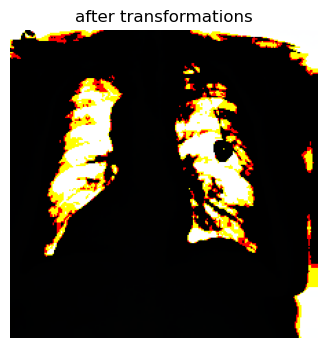

metatensor([[[-0.6144, -0.6414, -0.6383,  ..., -0.0565, -0.0421, -0.0276],
         [-0.6260, -0.6445, -0.6424,  ...,  0.0290,  0.0449,  0.0609],
         [-0.6328, -0.6491, -0.6473,  ...,  0.1304,  0.1520,  0.1736],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ..., -0.1888, -0.1723, -0.1860],
         [ 2.2472,  2.2468,  2.2469,  ..., -0.1859, -0.1694, -0.1916],
         [ 2.2369,  2.2347,  2.2350,  ..., -0.1831, -0.1672, -0.1965]],

        [[-0.4987, -0.5262, -0.5231,  ...,  0.0717,  0.0865,  0.1013],
         [-0.5105, -0.5294, -0.5273,  ...,  0.1591,  0.1754,  0.1917],
         [-0.5175, -0.5341, -0.5322,  ...,  0.2628,  0.2849,  0.3070],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0636, -0.0467, -0.0607],
         [ 2.4268,  2.4264,  2.4265,  ..., -0.0606, -0.0437, -0.0664],
         [ 2.4163,  2.4140,  2.4143,  ..., -0.0577, -0.0415, -0.0714]],

        [[-0.2742, -0.3016, -0.2986,  ...,  0.2936,  0.3083,  0.3230],
         [-0.2860, -0.3049, -0.3027,  ...

In [16]:
test_data2 = transform(test_data, "train")

import matplotlib.pyplot as plt
import numpy as np

img0_hwc = test_data2[99].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(4,4))
plt.imshow(np.rot90(img0_hwc.astype("uint8"),k=3))
plt.axis("off")
plt.title("after transformations")
plt.show()

test_data2[0]


In [17]:
class add_split_class(Dataset):
    
    """
    A custom Dataset wrapper that adds 'class' and 'split' metadata based on file paths without modifying image tensors or transforms.

    """
    
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.paths = base_dataset.data  # original image paths

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image = self.base_dataset[idx]  # tensor, unchanged
        path = Path(self.paths[idx])

        return {
            "image": image,
            "path": str(path),
            "class": path.parent.name,        # normal / pneumonia / tuberculosis
            "split": path.parent.parent.name,      # train / val / test
        }


In [18]:
# test

x= add_split_class(test_data2)
len(x)

x[0].keys()
x[0]["image"]

metatensor([[[ 2.2234,  2.2233,  2.2233,  ..., -1.8610, -1.8610, -1.8610],
         [ 2.2230,  2.2230,  2.2232,  ..., -1.8610, -1.8610, -1.8610],
         [ 2.2236,  2.2235,  2.2233,  ..., -1.8610, -1.8610, -1.8610],
         ...,
         [ 1.6892,  1.1098,  0.1310,  ..., -2.0837, -2.0837, -2.0837],
         [ 1.5936,  0.8377, -0.2186,  ..., -2.0662, -2.0654, -2.0647],
         [ 1.4853,  0.5634, -0.5702,  ..., -2.0361, -2.0350, -2.0338]],

        [[ 2.4025,  2.4024,  2.4023,  ..., -1.7731, -1.7731, -1.7731],
         [ 2.4021,  2.4021,  2.4022,  ..., -1.7731, -1.7731, -1.7731],
         [ 2.4027,  2.4026,  2.4024,  ..., -1.7731, -1.7731, -1.7731],
         ...,
         [ 1.8564,  1.2640,  0.2634,  ..., -2.0007, -2.0007, -2.0007],
         [ 1.7586,  0.9859, -0.0940,  ..., -1.9829, -1.9821, -1.9813],
         [ 1.6480,  0.7055, -0.4535,  ..., -1.9521, -1.9509, -1.9498]],

        [[ 2.6140,  2.6140,  2.6139,  ..., -1.5430, -1.5430, -1.5430],
         [ 2.6136,  2.6137,  2.6138,  ...

In [19]:
# testing indexing and subsetting

train_indices = [
    i for i, p in enumerate(x.paths)
    if Path(p).parent.parent.name == "train"
]

train_indices 

from torch.utils.data import Subset

train_data = Subset(x, train_indices)
len(train_data)

11534

In [20]:
def get_split(dataset, split_name):
    """
    Return a subset of the dataset corresponding to the given split.
    """
    indices = [
        i for i, p in enumerate(dataset.paths)
        if Path(p).parent.parent.name == split_name
    ]
    return Subset(dataset, indices)

In [21]:
train_data = get_split(x, "train")
len(train_data)
#train_data[0]["class"]

11534

In [22]:
def load_split(split):
    """
    Load a specific split ('train', 'val', or 'test') from the labeled dataset.
    """
    clean_data()
    raw_data = data_load(data_dir='../data/interim/cleaned_data', inspect=False)
    transformed_data = transform(raw_data, type="train")
    labeled_data = add_split_class(transformed_data)
    split_data = get_split(labeled_data, split)
    
    return split_data

In [23]:
# clean_data()
# raw_data =data_load(data_dir='../data/interim/cleaned_data', inspect=True, n_samples=5)
# transformed_data = transform(raw_data)
# labeled_data = add_split_class(transformed_data)
# train_data = get_split(labeled_data,'train')

# labeled_data[0]

x = load_split('train')
len(x)

[INFO] ../data/interim/cleaned_data already exists.
Transformation + augmentation done successfully on training data.
Transformation done successfully.


11534

# modify transform


In [15]:
class GCLAHE(Transform):
    """
    
    Create a Global-CLAHE transformation for image enhancement more suited for medical images.
    improves local contrast while preserving anatomical detail in medical images

    """
    
    def __init__(self, tile_grid_size=(8, 8), max_clip_limit=3.0):
        self.tile_grid_size = tile_grid_size
        self.max_clip_limit = max_clip_limit

    def __call__(self, img_tensor):
        #  (C, H, W) tensor to (H, W, C) numpy for ease of channel processing now. Will reverse it back later
        img_np = img_tensor.detach().cpu().numpy()
        
        processed_channels = []
        # Process each of the 3 channels individually
        for c in range(img_np.shape[0]):
            # 1. Scale to uint8 for OpenCV
            channel = (img_np[c] * 255).astype(np.uint8)
            
            # 2. Global Reference (GEI)
            gei = cv2.equalizeHist(channel)
            
            # 3. Local Enhancement (CLAHE)
            clahe = cv2.createCLAHE(clipLimit=self.max_clip_limit, tileGridSize=self.tile_grid_size)
            lei = clahe.apply(channel)
            
            # 4. G-CLAHE Blending: Maintain global brightness consistency
            # 50/50 blend is common to prevent local artifacts
            g_clahe_channel = cv2.addWeighted(lei, 0.5, gei, 0.5, 0)
            
            processed_channels.append(g_clahe_channel.astype(np.float32) / 255.0)
            
        # back to (3, H, W)
        return torch.from_numpy(np.stack(processed_channels))

def transform(dataset, type):
    """
    Return a new transformed Dataset
     a- convert to grayscale by averaging channels since some images have incononsistent channels
     b- repeat channels to have 3 channels again.
     c- resize to 224x224
     d- pad to ensure 224x224
     e- scale intensity to [0,1]
     f- apply G-CLAHE Transform class
     g- normalize intensity with ImageNet stats

    Parameters
    ----------
    dataset : monai.data.Dataset
        Existing dataset (paths will be reused).

    Returns
    -------
    dataset_transformed : monai.data.Dataset
        New dataset after applying the transformations.
    """
    image_paths = dataset.data  
    
    to_gray = Lambda(lambda x: x.mean(dim=0, keepdim=True))

    base_transforms = [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        to_gray,
        RepeatChannel(3),
        Resize((224, 224), mode='bilinear'),
        SpatialPad(spatial_size=(224, 224), method="symmetric"),
        ScaleIntensity(),               # [0,255] → [0,1]
        GCLAHE(tile_grid_size=(8, 8), max_clip_limit=3.0),
        NormalizeIntensity(
        subtrahend =[0.485, 0.456, 0.406],
        divisor=[0.229, 0.224, 0.225],
        channel_wise=True,
        ),
        
    ]
    
    train_augments = [
        # Small rotations (medical-safe)
        RandRotate(
            range_x=10 * 3.1416 / 180,   # ±10 degrees
            prob=0.5,
        ),

        # Mild affine transforms
        RandAffine(
            translate_range=(10, 10),
            scale_range=(0.1, 0.1),
            prob=0.5,
        ),

        # Horizontal flip only (lungs are symmetric)
        RandFlip(
            spatial_axis=1,
            prob=0.5,
        ),

        # Sensor / acquisition noise
        RandGaussianNoise(
            mean=0.0,
            std=0.01,
            prob=0.3,
        ),
    ]
    
    train_transforms = base_transforms + train_augments
    
    if type == "train":
        dataset_transformed = Dataset(
            data=image_paths,
            transform=train_transforms)
        print(f"Transformation + augmentation done successfully on training data.")
    else: 
        dataset_transformed = Dataset(
        data=image_paths,
        transform=base_transforms
        )
        print(f"Transformation done successfully.")
    
    print(f"Transformation done successfully.")
    return dataset_transformed


Transformation + augmentation done successfully on training data.
Transformation done successfully.


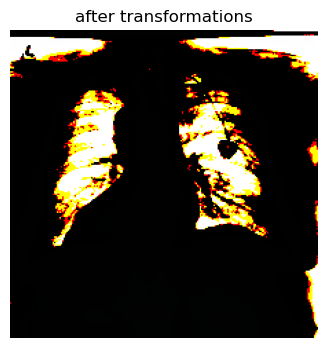

metatensor([[[-1.9457, -1.9051, -1.8729,  ...,  0.4541, -0.3541, -0.3573],
         [-1.8083, -1.7814, -1.7594,  ...,  0.4307, -0.2571, -0.3333],
         [-1.6913, -1.6727, -1.6649,  ...,  0.4338, -0.2476, -0.4294],
         ...,
         [-2.0837, -2.0837, -2.0837,  ...,  0.7648, -1.4190, -2.0219],
         [-2.0837, -2.0837, -2.0837,  ...,  0.7907, -1.3915, -2.0211],
         [-2.0837, -2.0837, -2.0837,  ...,  0.8168, -1.2776, -1.9911]],

        [[-1.8596, -1.8182, -1.7852,  ...,  0.5937, -0.2325, -0.2358],
         [-1.7192, -1.6917, -1.6692,  ...,  0.5698, -0.1333, -0.2112],
         [-1.5996, -1.5806, -1.5726,  ...,  0.5730, -0.1237, -0.3095],
         ...,
         [-2.0007, -2.0007, -2.0007,  ...,  0.9114, -1.3212, -1.9376],
         [-2.0007, -2.0007, -2.0007,  ...,  0.9378, -1.2930, -1.9367],
         [-2.0007, -2.0007, -2.0007,  ...,  0.9645, -1.1766, -1.9061]],

        [[-1.6292, -1.5879, -1.5551,  ...,  0.8133, -0.0092, -0.0125],
         [-1.4894, -1.4619, -1.4395,  ...

In [24]:
test_data2 = transform(test_data, type="train")

import matplotlib.pyplot as plt
import numpy as np

img0_hwc = test_data2[99].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(4,4))
plt.imshow(np.rot90(img0_hwc.astype("uint8"),k=3))
plt.axis("off")
plt.title("after transformations")
plt.show()

test_data2[0]

In [25]:
x = load_split('train')
len(x)
x[0]

[INFO] ../data/interim/cleaned_data already exists.
Transformation + augmentation done successfully on training data.
Transformation done successfully.


{'image': metatensor([[[ 1.0159,  0.6563,  0.4166,  ..., -1.7412, -1.7583, -1.7240],
          [ 0.9303,  0.4851,  0.1768,  ..., -2.0152, -2.0152, -2.0152],
          [ 0.7762,  0.3481,  0.0056,  ..., -2.0837, -2.0837, -2.0837],
          ...,
          [ 1.2385,  1.1872,  1.0844,  ..., -2.0837, -2.0837, -2.0837],
          [ 1.5468,  1.6838,  1.6838,  ..., -2.0837, -2.0494, -1.9467],
          [ 2.2318,  2.1633,  2.1975,  ..., -1.9124, -1.9467, -1.6213]],
 
         [[ 1.1681,  0.8004,  0.5553,  ..., -1.6506, -1.6681, -1.6331],
          [ 1.0805,  0.6254,  0.3102,  ..., -1.9307, -1.9307, -1.9307],
          [ 0.9230,  0.4853,  0.1352,  ..., -2.0007, -2.0007, -2.0007],
          ...,
          [ 1.3957,  1.3431,  1.2381,  ..., -2.0007, -2.0007, -2.0007],
          [ 1.7108,  1.8508,  1.8508,  ..., -2.0007, -1.9657, -1.8606],
          [ 2.4111,  2.3410,  2.3761,  ..., -1.8256, -1.8606, -1.5280]],
 
         [[ 1.3851,  1.0191,  0.7751,  ..., -1.4210, -1.4384, -1.4036],
          [ 1.2